In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [47]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=2500,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [48]:
runs = [304125,304508,302263]

with open('pileupInput_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('pileupInput_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])



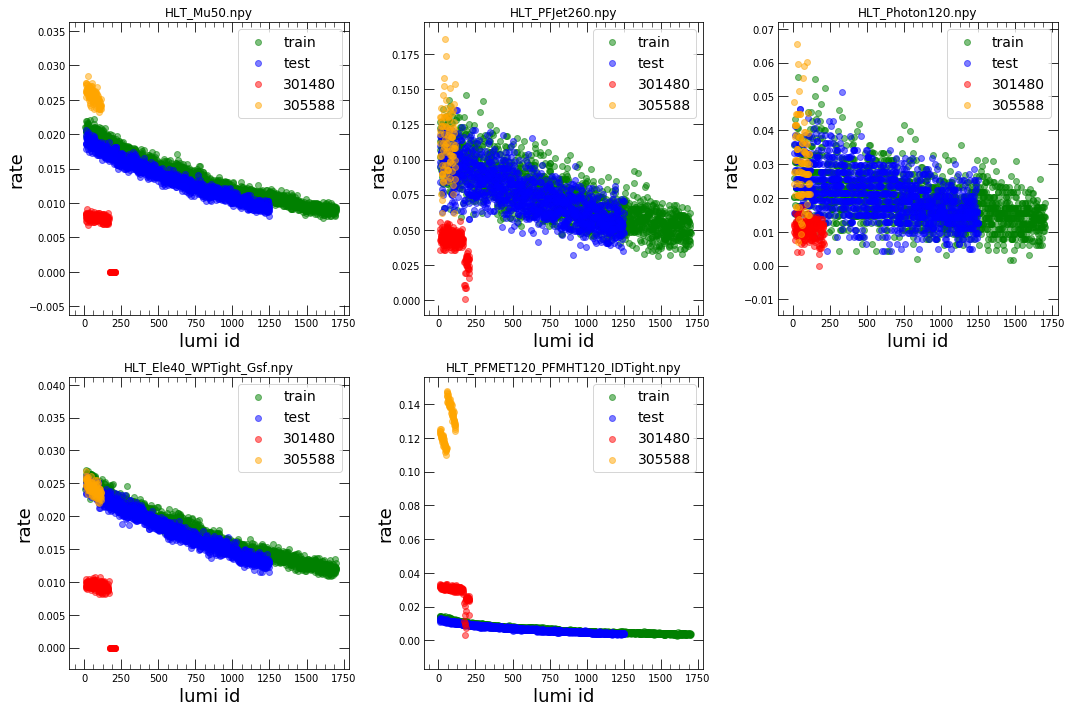

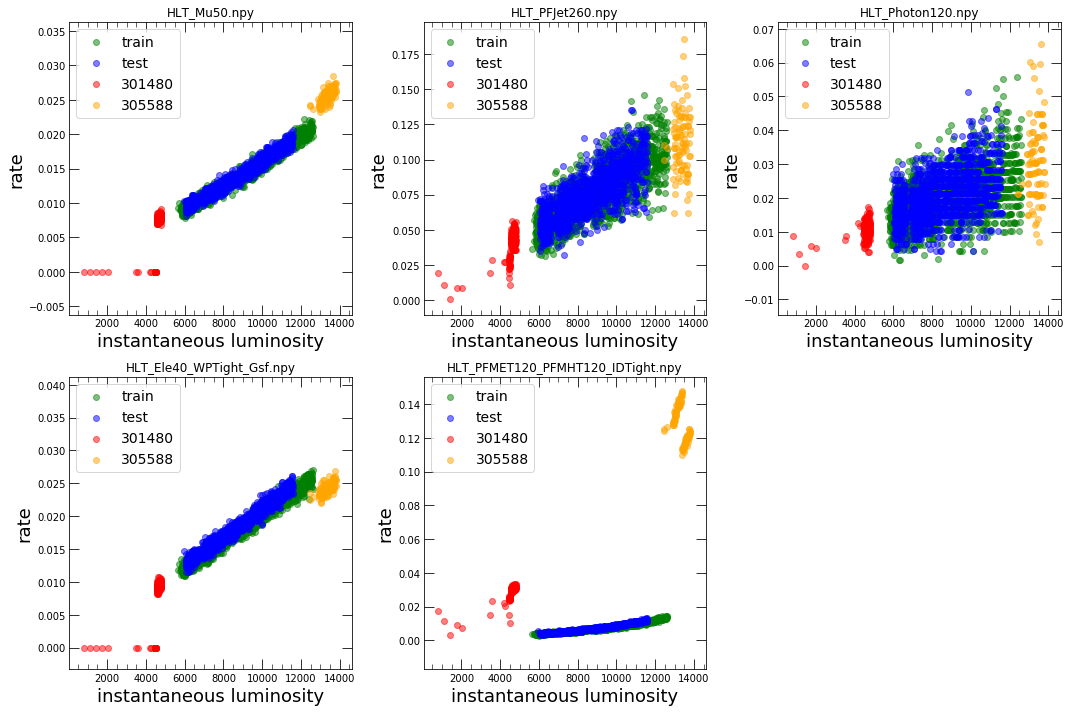

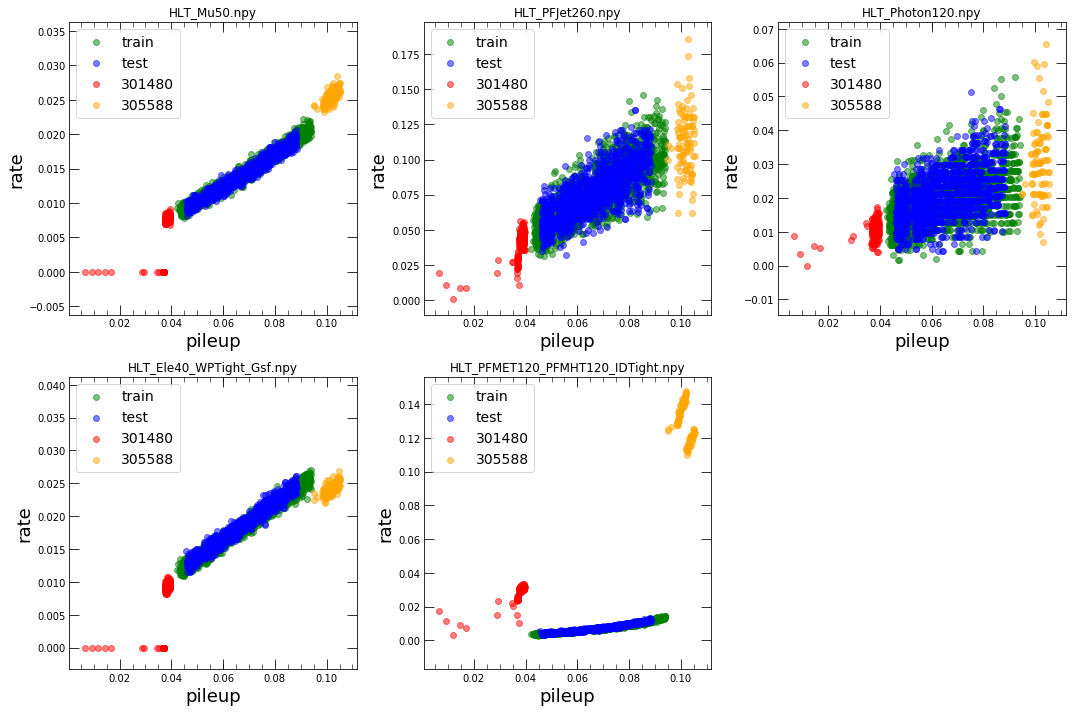

In [49]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(5):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [50]:
model_name = "pileupInputMoreLayers"

In [64]:
# Define the architecture

_input = Input(shape=(6,), name="input")

#hidden1 = Dense(6,
#               kernel_initializer=Ones(),
#               bias_initializer=Zeros(),
#               kernel_constraint=non_neg(),
#               bias_constraint=non_neg(),
#               activation = 'relu',
#               name="hidden1")(_input)

hidden2 = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="hidden2")(_input)

hidden3 = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(hidden2)

hidden4 = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="hidden4")(hidden3)

#hidden5 = Dense(6,
#               kernel_initializer=Ones(),
#               bias_initializer=Zeros(),
#               kernel_constraint=non_neg(),
#               bias_constraint=non_neg(),
#               activation = 'relu',
#               name="hidden5")(hidden4)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden4)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 28        
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
hidden4 (Dense)              (None, 4)                 16        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 30        
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/2500
 - 3s - loss: 91.0863 - val_loss: 89.1910
Epoch 2/2500
 - 0s - loss: 87.1227 - val_loss: 84.9733
Epoch 3/2500
 - 0s - loss: 83.0383 - val_loss: 81.0293
Epoch 4/2500
 - 0s - loss: 79.1311 - val_loss: 77.2113
Epoch 5/2500
 - 0s - loss: 75.4096 - val_loss: 73.5722
Epoch 6/2500
 - 0s - loss: 71.8629 - val_loss: 70.0898
Epoch 7/2500
 - 0s - loss: 68.4529 - val_loss: 66.7742
Epoch 8/2500
 - 0s - loss: 65.2126 - val_loss: 63.6381
Epoch 9/2500
 - 0s - loss: 62.1606 - val_loss: 60.6541
Epoch 10/2500
 - 0s - loss: 59.2427 - val_loss: 57.8160
Epoch 11/2500
 - 0s - loss: 56.4779 - val_loss: 55.1602
Epoch 12/2500
 - 0s - loss: 53.8758 - val_loss: 52.6370
Epoch 13/2500
 - 0s - loss: 51.4348 - val_loss: 50.2393
Epoch 14/2500
 - 0s - loss: 49.0861 - val_loss: 47.9922
Epoch 15/2500
 - 0s - loss: 46.8963 - val_loss: 45.8835
Epoch 16/2500
 - 0s - loss: 44.8453 - val_loss: 43.8815
Epoch 17/2500
 - 0s - loss: 42.8898 - val_loss: 42.0051
Epoch 18/

Epoch 149/2500
 - 0s - loss: 2.4600 - val_loss: 2.4712
Epoch 150/2500
 - 0s - loss: 2.4306 - val_loss: 2.4418
Epoch 151/2500
 - 0s - loss: 2.4017 - val_loss: 2.4128
Epoch 152/2500
 - 0s - loss: 2.3731 - val_loss: 2.3844
Epoch 153/2500
 - 0s - loss: 2.3452 - val_loss: 2.3564
Epoch 154/2500
 - 0s - loss: 2.3179 - val_loss: 2.3289
Epoch 155/2500
 - 0s - loss: 2.2907 - val_loss: 2.3020
Epoch 156/2500
 - 0s - loss: 2.2641 - val_loss: 2.2754
Epoch 157/2500
 - 0s - loss: 2.2380 - val_loss: 2.2493
Epoch 158/2500
 - 0s - loss: 2.2124 - val_loss: 2.2235
Epoch 159/2500
 - 0s - loss: 2.1872 - val_loss: 2.1982
Epoch 160/2500
 - 0s - loss: 2.1623 - val_loss: 2.1733
Epoch 161/2500
 - 0s - loss: 2.1378 - val_loss: 2.1488
Epoch 162/2500
 - 0s - loss: 2.1137 - val_loss: 2.1248
Epoch 163/2500
 - 0s - loss: 2.0900 - val_loss: 2.1011
Epoch 164/2500
 - 0s - loss: 2.0668 - val_loss: 2.0777
Epoch 165/2500
 - 0s - loss: 2.0440 - val_loss: 2.0548
Epoch 166/2500
 - 0s - loss: 2.0213 - val_loss: 2.0322
Epoch 167/

Epoch 298/2500
 - 0s - loss: 0.6509 - val_loss: 0.6567
Epoch 299/2500
 - 0s - loss: 0.6465 - val_loss: 0.6522
Epoch 300/2500
 - 0s - loss: 0.6421 - val_loss: 0.6478
Epoch 301/2500
 - 0s - loss: 0.6378 - val_loss: 0.6434
Epoch 302/2500
 - 0s - loss: 0.6335 - val_loss: 0.6391
Epoch 303/2500
 - 0s - loss: 0.6292 - val_loss: 0.6348
Epoch 304/2500
 - 0s - loss: 0.6250 - val_loss: 0.6306
Epoch 305/2500
 - 0s - loss: 0.6208 - val_loss: 0.6263
Epoch 306/2500
 - 0s - loss: 0.6167 - val_loss: 0.6222
Epoch 307/2500
 - 0s - loss: 0.6125 - val_loss: 0.6180
Epoch 308/2500
 - 0s - loss: 0.6085 - val_loss: 0.6139
Epoch 309/2500
 - 0s - loss: 0.6045 - val_loss: 0.6099
Epoch 310/2500
 - 0s - loss: 0.6005 - val_loss: 0.6059
Epoch 311/2500
 - 0s - loss: 0.5965 - val_loss: 0.6019
Epoch 312/2500
 - 0s - loss: 0.5926 - val_loss: 0.5980
Epoch 313/2500
 - 0s - loss: 0.5887 - val_loss: 0.5941
Epoch 314/2500
 - 0s - loss: 0.5849 - val_loss: 0.5902
Epoch 315/2500
 - 0s - loss: 0.5811 - val_loss: 0.5863
Epoch 316/

Epoch 447/2500
 - 0s - loss: 0.2770 - val_loss: 0.2798
Epoch 448/2500
 - 0s - loss: 0.2756 - val_loss: 0.2785
Epoch 449/2500
 - 0s - loss: 0.2743 - val_loss: 0.2771
Epoch 450/2500
 - 0s - loss: 0.2729 - val_loss: 0.2758
Epoch 451/2500
 - 0s - loss: 0.2716 - val_loss: 0.2744
Epoch 452/2500
 - 0s - loss: 0.2703 - val_loss: 0.2731
Epoch 453/2500
 - 0s - loss: 0.2690 - val_loss: 0.2718
Epoch 454/2500
 - 0s - loss: 0.2677 - val_loss: 0.2705
Epoch 455/2500
 - 0s - loss: 0.2664 - val_loss: 0.2692
Epoch 456/2500
 - 0s - loss: 0.2651 - val_loss: 0.2679
Epoch 457/2500
 - 0s - loss: 0.2639 - val_loss: 0.2666
Epoch 458/2500
 - 0s - loss: 0.2626 - val_loss: 0.2653
Epoch 459/2500
 - 0s - loss: 0.2613 - val_loss: 0.2641
Epoch 460/2500
 - 0s - loss: 0.2601 - val_loss: 0.2628
Epoch 461/2500
 - 0s - loss: 0.2589 - val_loss: 0.2616
Epoch 462/2500
 - 0s - loss: 0.2576 - val_loss: 0.2603
Epoch 463/2500
 - 0s - loss: 0.2564 - val_loss: 0.2591
Epoch 464/2500
 - 0s - loss: 0.2552 - val_loss: 0.2579
Epoch 465/

Epoch 596/2500
 - 0s - loss: 0.1450 - val_loss: 0.1466
Epoch 597/2500
 - 0s - loss: 0.1444 - val_loss: 0.1461
Epoch 598/2500
 - 0s - loss: 0.1439 - val_loss: 0.1455
Epoch 599/2500
 - 0s - loss: 0.1433 - val_loss: 0.1449
Epoch 600/2500
 - 0s - loss: 0.1428 - val_loss: 0.1444
Epoch 601/2500
 - 0s - loss: 0.1422 - val_loss: 0.1438
Epoch 602/2500
 - 0s - loss: 0.1417 - val_loss: 0.1433
Epoch 603/2500
 - 0s - loss: 0.1411 - val_loss: 0.1427
Epoch 604/2500
 - 0s - loss: 0.1406 - val_loss: 0.1422
Epoch 605/2500
 - 0s - loss: 0.1400 - val_loss: 0.1416
Epoch 606/2500
 - 0s - loss: 0.1395 - val_loss: 0.1411
Epoch 607/2500
 - 0s - loss: 0.1390 - val_loss: 0.1405
Epoch 608/2500
 - 0s - loss: 0.1384 - val_loss: 0.1400
Epoch 609/2500
 - 0s - loss: 0.1379 - val_loss: 0.1395
Epoch 610/2500
 - 0s - loss: 0.1374 - val_loss: 0.1389
Epoch 611/2500
 - 0s - loss: 0.1369 - val_loss: 0.1384
Epoch 612/2500
 - 0s - loss: 0.1363 - val_loss: 0.1379
Epoch 613/2500
 - 0s - loss: 0.1358 - val_loss: 0.1373
Epoch 614/

Epoch 745/2500
 - 0s - loss: 0.0852 - val_loss: 0.0862
Epoch 746/2500
 - 0s - loss: 0.0849 - val_loss: 0.0859
Epoch 747/2500
 - 0s - loss: 0.0846 - val_loss: 0.0856
Epoch 748/2500
 - 0s - loss: 0.0843 - val_loss: 0.0853
Epoch 749/2500
 - 0s - loss: 0.0841 - val_loss: 0.0850
Epoch 750/2500
 - 0s - loss: 0.0838 - val_loss: 0.0848
Epoch 751/2500
 - 0s - loss: 0.0835 - val_loss: 0.0845
Epoch 752/2500
 - 0s - loss: 0.0832 - val_loss: 0.0842
Epoch 753/2500
 - 0s - loss: 0.0830 - val_loss: 0.0839
Epoch 754/2500
 - 0s - loss: 0.0827 - val_loss: 0.0837
Epoch 755/2500
 - 0s - loss: 0.0824 - val_loss: 0.0834
Epoch 756/2500
 - 0s - loss: 0.0822 - val_loss: 0.0831
Epoch 757/2500
 - 0s - loss: 0.0819 - val_loss: 0.0829
Epoch 758/2500
 - 0s - loss: 0.0816 - val_loss: 0.0826
Epoch 759/2500
 - 0s - loss: 0.0814 - val_loss: 0.0823
Epoch 760/2500
 - 0s - loss: 0.0811 - val_loss: 0.0820
Epoch 761/2500
 - 0s - loss: 0.0808 - val_loss: 0.0818
Epoch 762/2500
 - 0s - loss: 0.0806 - val_loss: 0.0815
Epoch 763/

Epoch 894/2500
 - 0s - loss: 0.0538 - val_loss: 0.0544
Epoch 895/2500
 - 0s - loss: 0.0536 - val_loss: 0.0543
Epoch 896/2500
 - 0s - loss: 0.0535 - val_loss: 0.0541
Epoch 897/2500
 - 0s - loss: 0.0533 - val_loss: 0.0540
Epoch 898/2500
 - 0s - loss: 0.0532 - val_loss: 0.0538
Epoch 899/2500
 - 0s - loss: 0.0530 - val_loss: 0.0537
Epoch 900/2500
 - 0s - loss: 0.0529 - val_loss: 0.0535
Epoch 901/2500
 - 0s - loss: 0.0527 - val_loss: 0.0534
Epoch 902/2500
 - 0s - loss: 0.0526 - val_loss: 0.0532
Epoch 903/2500
 - 0s - loss: 0.0524 - val_loss: 0.0530
Epoch 904/2500
 - 0s - loss: 0.0523 - val_loss: 0.0529
Epoch 905/2500
 - 0s - loss: 0.0521 - val_loss: 0.0527
Epoch 906/2500
 - 0s - loss: 0.0520 - val_loss: 0.0526
Epoch 907/2500
 - 0s - loss: 0.0518 - val_loss: 0.0524
Epoch 908/2500
 - 0s - loss: 0.0517 - val_loss: 0.0523
Epoch 909/2500
 - 0s - loss: 0.0515 - val_loss: 0.0521
Epoch 910/2500
 - 0s - loss: 0.0514 - val_loss: 0.0520
Epoch 911/2500
 - 0s - loss: 0.0512 - val_loss: 0.0518
Epoch 912/

Epoch 1043/2500
 - 0s - loss: 0.0357 - val_loss: 0.0361
Epoch 1044/2500
 - 0s - loss: 0.0356 - val_loss: 0.0360
Epoch 1045/2500
 - 0s - loss: 0.0355 - val_loss: 0.0359
Epoch 1046/2500
 - 0s - loss: 0.0354 - val_loss: 0.0358
Epoch 1047/2500
 - 0s - loss: 0.0353 - val_loss: 0.0357
Epoch 1048/2500
 - 0s - loss: 0.0352 - val_loss: 0.0357
Epoch 1049/2500
 - 0s - loss: 0.0351 - val_loss: 0.0356
Epoch 1050/2500
 - 0s - loss: 0.0350 - val_loss: 0.0355
Epoch 1051/2500
 - 0s - loss: 0.0350 - val_loss: 0.0354
Epoch 1052/2500
 - 0s - loss: 0.0349 - val_loss: 0.0353
Epoch 1053/2500
 - 0s - loss: 0.0348 - val_loss: 0.0352
Epoch 1054/2500
 - 0s - loss: 0.0347 - val_loss: 0.0351
Epoch 1055/2500
 - 0s - loss: 0.0346 - val_loss: 0.0350
Epoch 1056/2500
 - 0s - loss: 0.0345 - val_loss: 0.0349
Epoch 1057/2500
 - 0s - loss: 0.0344 - val_loss: 0.0348
Epoch 1058/2500
 - 0s - loss: 0.0343 - val_loss: 0.0347
Epoch 1059/2500
 - 0s - loss: 0.0342 - val_loss: 0.0346
Epoch 1060/2500
 - 0s - loss: 0.0341 - val_loss:

Epoch 1190/2500
 - 0s - loss: 0.0246 - val_loss: 0.0249
Epoch 1191/2500
 - 0s - loss: 0.0246 - val_loss: 0.0249
Epoch 1192/2500
 - 0s - loss: 0.0245 - val_loss: 0.0248
Epoch 1193/2500
 - 0s - loss: 0.0245 - val_loss: 0.0248
Epoch 1194/2500
 - 0s - loss: 0.0244 - val_loss: 0.0247
Epoch 1195/2500
 - 0s - loss: 0.0243 - val_loss: 0.0246
Epoch 1196/2500
 - 0s - loss: 0.0243 - val_loss: 0.0246
Epoch 1197/2500
 - 0s - loss: 0.0242 - val_loss: 0.0245
Epoch 1198/2500
 - 0s - loss: 0.0242 - val_loss: 0.0245
Epoch 1199/2500
 - 0s - loss: 0.0241 - val_loss: 0.0244
Epoch 1200/2500
 - 0s - loss: 0.0241 - val_loss: 0.0243
Epoch 1201/2500
 - 0s - loss: 0.0240 - val_loss: 0.0243
Epoch 1202/2500
 - 0s - loss: 0.0239 - val_loss: 0.0242
Epoch 1203/2500
 - 0s - loss: 0.0239 - val_loss: 0.0242
Epoch 1204/2500
 - 0s - loss: 0.0238 - val_loss: 0.0241
Epoch 1205/2500
 - 0s - loss: 0.0238 - val_loss: 0.0240
Epoch 1206/2500
 - 0s - loss: 0.0237 - val_loss: 0.0240
Epoch 1207/2500
 - 0s - loss: 0.0236 - val_loss:

Epoch 1337/2500
 - 0s - loss: 0.0174 - val_loss: 0.0177
Epoch 1338/2500
 - 0s - loss: 0.0174 - val_loss: 0.0176
Epoch 1339/2500
 - 0s - loss: 0.0174 - val_loss: 0.0176
Epoch 1340/2500
 - 0s - loss: 0.0173 - val_loss: 0.0175
Epoch 1341/2500
 - 0s - loss: 0.0173 - val_loss: 0.0175
Epoch 1342/2500
 - 0s - loss: 0.0172 - val_loss: 0.0175
Epoch 1343/2500
 - 0s - loss: 0.0172 - val_loss: 0.0174
Epoch 1344/2500
 - 0s - loss: 0.0172 - val_loss: 0.0174
Epoch 1345/2500
 - 0s - loss: 0.0171 - val_loss: 0.0173
Epoch 1346/2500
 - 0s - loss: 0.0171 - val_loss: 0.0173
Epoch 1347/2500
 - 0s - loss: 0.0171 - val_loss: 0.0173
Epoch 1348/2500
 - 0s - loss: 0.0170 - val_loss: 0.0172
Epoch 1349/2500
 - 0s - loss: 0.0170 - val_loss: 0.0172
Epoch 1350/2500
 - 0s - loss: 0.0169 - val_loss: 0.0171
Epoch 1351/2500
 - 0s - loss: 0.0169 - val_loss: 0.0171
Epoch 1352/2500
 - 0s - loss: 0.0169 - val_loss: 0.0171
Epoch 1353/2500
 - 0s - loss: 0.0168 - val_loss: 0.0170
Epoch 1354/2500
 - 0s - loss: 0.0168 - val_loss:

Epoch 1484/2500
 - 0s - loss: 0.0126 - val_loss: 0.0127
Epoch 1485/2500
 - 0s - loss: 0.0126 - val_loss: 0.0127
Epoch 1486/2500
 - 0s - loss: 0.0125 - val_loss: 0.0127
Epoch 1487/2500
 - 0s - loss: 0.0125 - val_loss: 0.0127
Epoch 1488/2500
 - 0s - loss: 0.0125 - val_loss: 0.0126
Epoch 1489/2500
 - 0s - loss: 0.0125 - val_loss: 0.0126
Epoch 1490/2500
 - 0s - loss: 0.0124 - val_loss: 0.0126
Epoch 1491/2500
 - 0s - loss: 0.0124 - val_loss: 0.0125
Epoch 1492/2500
 - 0s - loss: 0.0124 - val_loss: 0.0125
Epoch 1493/2500
 - 0s - loss: 0.0123 - val_loss: 0.0125
Epoch 1494/2500
 - 0s - loss: 0.0123 - val_loss: 0.0125
Epoch 1495/2500
 - 0s - loss: 0.0123 - val_loss: 0.0124
Epoch 1496/2500
 - 0s - loss: 0.0123 - val_loss: 0.0124
Epoch 1497/2500
 - 0s - loss: 0.0122 - val_loss: 0.0124
Epoch 1498/2500
 - 0s - loss: 0.0122 - val_loss: 0.0124
Epoch 1499/2500
 - 0s - loss: 0.0122 - val_loss: 0.0123
Epoch 1500/2500
 - 0s - loss: 0.0122 - val_loss: 0.0123
Epoch 1501/2500
 - 0s - loss: 0.0121 - val_loss:

Epoch 1631/2500
 - 0s - loss: 0.0092 - val_loss: 0.0093
Epoch 1632/2500
 - 0s - loss: 0.0092 - val_loss: 0.0093
Epoch 1633/2500
 - 0s - loss: 0.0092 - val_loss: 0.0093
Epoch 1634/2500
 - 0s - loss: 0.0092 - val_loss: 0.0093
Epoch 1635/2500
 - 0s - loss: 0.0091 - val_loss: 0.0093
Epoch 1636/2500
 - 0s - loss: 0.0091 - val_loss: 0.0092
Epoch 1637/2500
 - 0s - loss: 0.0091 - val_loss: 0.0092
Epoch 1638/2500
 - 0s - loss: 0.0091 - val_loss: 0.0092
Epoch 1639/2500
 - 0s - loss: 0.0091 - val_loss: 0.0092
Epoch 1640/2500
 - 0s - loss: 0.0091 - val_loss: 0.0092
Epoch 1641/2500
 - 0s - loss: 0.0090 - val_loss: 0.0091
Epoch 1642/2500
 - 0s - loss: 0.0090 - val_loss: 0.0091
Epoch 1643/2500
 - 0s - loss: 0.0090 - val_loss: 0.0091
Epoch 1644/2500
 - 0s - loss: 0.0090 - val_loss: 0.0091
Epoch 1645/2500
 - 0s - loss: 0.0090 - val_loss: 0.0091
Epoch 1646/2500
 - 0s - loss: 0.0089 - val_loss: 0.0090
Epoch 1647/2500
 - 0s - loss: 0.0089 - val_loss: 0.0090
Epoch 1648/2500
 - 0s - loss: 0.0089 - val_loss:

Epoch 1778/2500
 - 0s - loss: 0.0068 - val_loss: 0.0069
Epoch 1779/2500
 - 0s - loss: 0.0068 - val_loss: 0.0069
Epoch 1780/2500
 - 0s - loss: 0.0068 - val_loss: 0.0069
Epoch 1781/2500
 - 0s - loss: 0.0068 - val_loss: 0.0069
Epoch 1782/2500
 - 0s - loss: 0.0068 - val_loss: 0.0069
Epoch 1783/2500
 - 0s - loss: 0.0068 - val_loss: 0.0068
Epoch 1784/2500
 - 0s - loss: 0.0068 - val_loss: 0.0068
Epoch 1785/2500
 - 0s - loss: 0.0067 - val_loss: 0.0068
Epoch 1786/2500
 - 0s - loss: 0.0067 - val_loss: 0.0068
Epoch 1787/2500
 - 0s - loss: 0.0067 - val_loss: 0.0068
Epoch 1788/2500
 - 0s - loss: 0.0067 - val_loss: 0.0068
Epoch 1789/2500
 - 0s - loss: 0.0067 - val_loss: 0.0068
Epoch 1790/2500
 - 0s - loss: 0.0067 - val_loss: 0.0067
Epoch 1791/2500
 - 0s - loss: 0.0067 - val_loss: 0.0067
Epoch 1792/2500
 - 0s - loss: 0.0066 - val_loss: 0.0067
Epoch 1793/2500
 - 0s - loss: 0.0066 - val_loss: 0.0067
Epoch 1794/2500
 - 0s - loss: 0.0066 - val_loss: 0.0067
Epoch 1795/2500
 - 0s - loss: 0.0066 - val_loss:

Epoch 1925/2500
 - 0s - loss: 0.0051 - val_loss: 0.0052
Epoch 1926/2500
 - 0s - loss: 0.0051 - val_loss: 0.0052
Epoch 1927/2500
 - 0s - loss: 0.0051 - val_loss: 0.0052
Epoch 1928/2500
 - 0s - loss: 0.0051 - val_loss: 0.0051
Epoch 1929/2500
 - 0s - loss: 0.0051 - val_loss: 0.0051
Epoch 1930/2500
 - 0s - loss: 0.0051 - val_loss: 0.0051
Epoch 1931/2500
 - 0s - loss: 0.0051 - val_loss: 0.0051
Epoch 1932/2500
 - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 1933/2500
 - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 1934/2500
 - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 1935/2500
 - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 1936/2500
 - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 1937/2500
 - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 1938/2500
 - 0s - loss: 0.0050 - val_loss: 0.0050
Epoch 1939/2500
 - 0s - loss: 0.0050 - val_loss: 0.0050
Epoch 1940/2500
 - 0s - loss: 0.0050 - val_loss: 0.0050
Epoch 1941/2500
 - 0s - loss: 0.0050 - val_loss: 0.0050
Epoch 1942/2500
 - 0s - loss: 0.0050 - val_loss:

Epoch 2072/2500
 - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 2073/2500
 - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 2074/2500
 - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 2075/2500
 - 0s - loss: 0.0038 - val_loss: 0.0039
Epoch 2076/2500
 - 0s - loss: 0.0038 - val_loss: 0.0039
Epoch 2077/2500
 - 0s - loss: 0.0038 - val_loss: 0.0039
Epoch 2078/2500
 - 0s - loss: 0.0038 - val_loss: 0.0039
Epoch 2079/2500
 - 0s - loss: 0.0038 - val_loss: 0.0039
Epoch 2080/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2081/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2082/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2083/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2084/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2085/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2086/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2087/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2088/2500
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 2089/2500
 - 0s - loss: 0.0037 - val_loss:

Epoch 2219/2500
 - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 2220/2500
 - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 2221/2500
 - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 2222/2500
 - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 2223/2500
 - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 2224/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2225/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2226/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2227/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2228/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2229/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2230/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2231/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2232/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2233/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2234/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2235/2500
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 2236/2500
 - 0s - loss: 0.0029 - val_loss:

Epoch 2366/2500
 - 0s - loss: 0.0023 - val_loss: 0.0023
Epoch 2367/2500
 - 0s - loss: 0.0023 - val_loss: 0.0023
Epoch 2368/2500
 - 0s - loss: 0.0023 - val_loss: 0.0023
Epoch 2369/2500
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 2370/2500
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 2371/2500
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 2372/2500
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 2373/2500
 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 2374/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2375/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2376/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2377/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2378/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2379/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2380/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2381/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2382/2500
 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 2383/2500
 - 0s - loss: 0.0022 - val_loss:

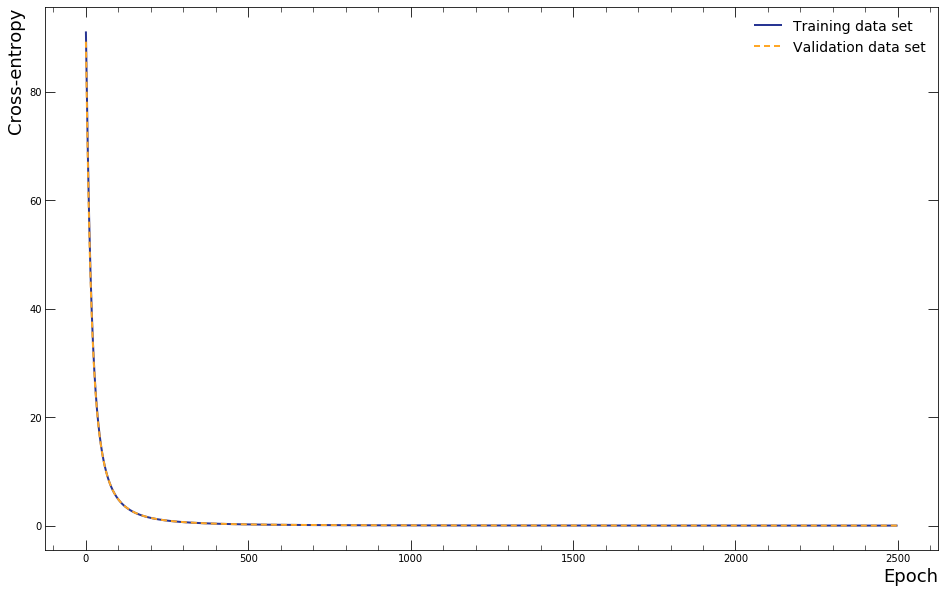

In [65]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

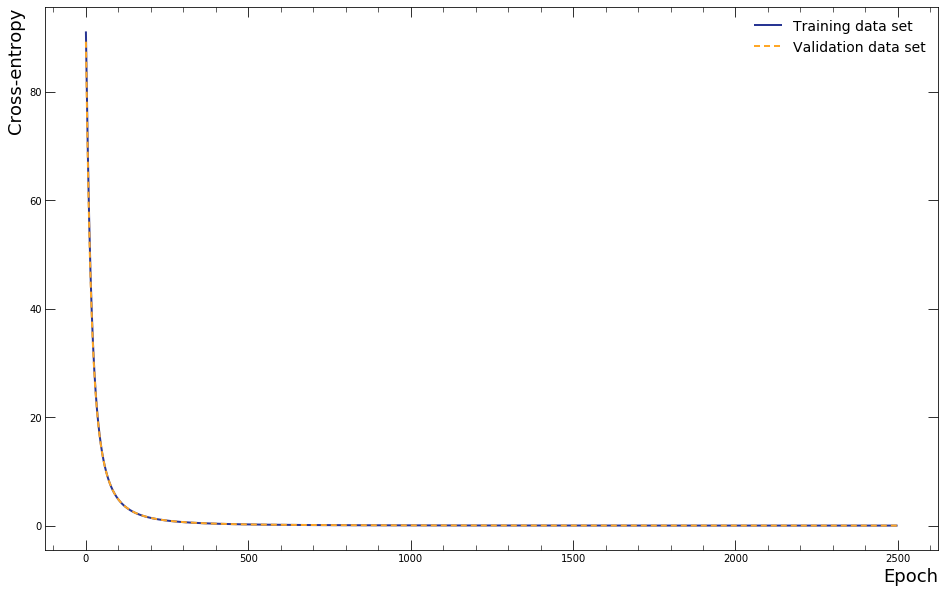

In [66]:
plot_loss(history)

## Training Set

In [67]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        lumi_new.append(lumi[l])
                
reconstructed = model.predict(np.array(x_train))

error = (x_train-reconstructed)/x_train

In [68]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_train_new[i][j])

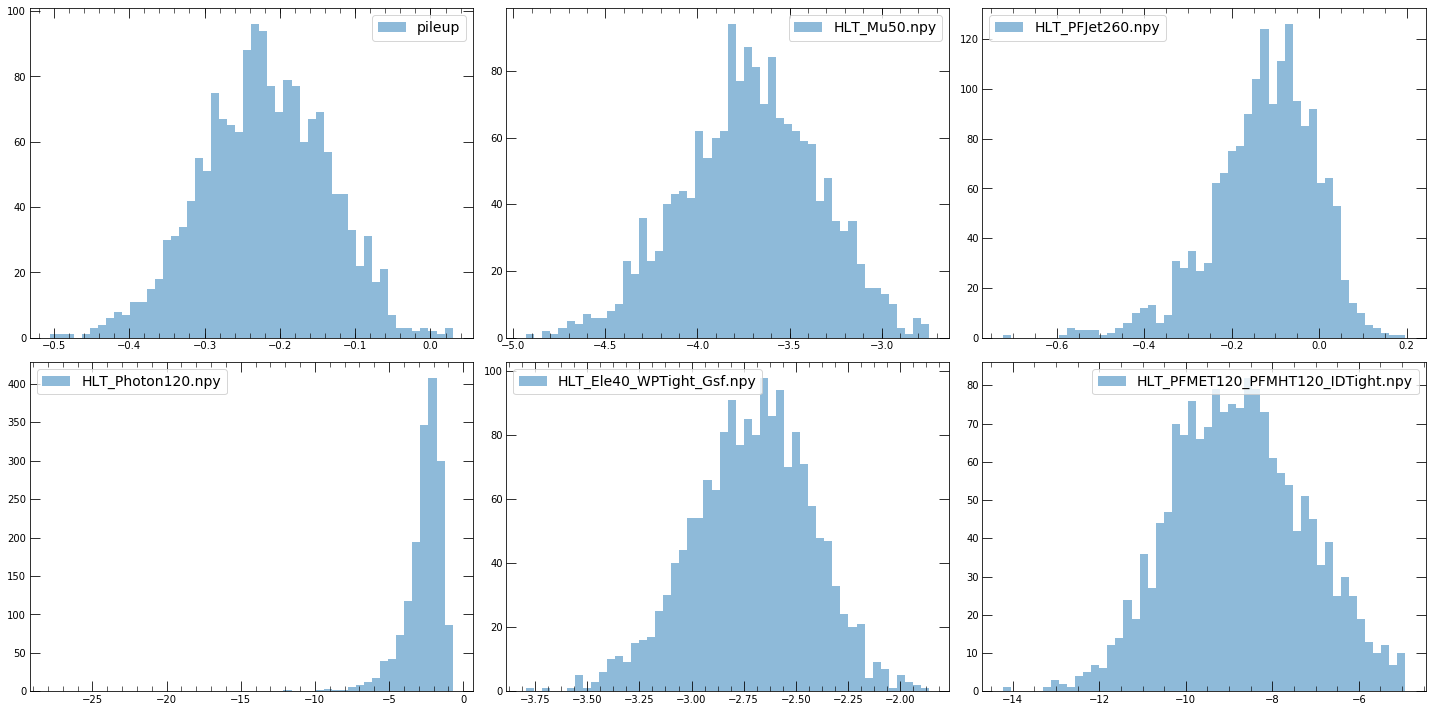

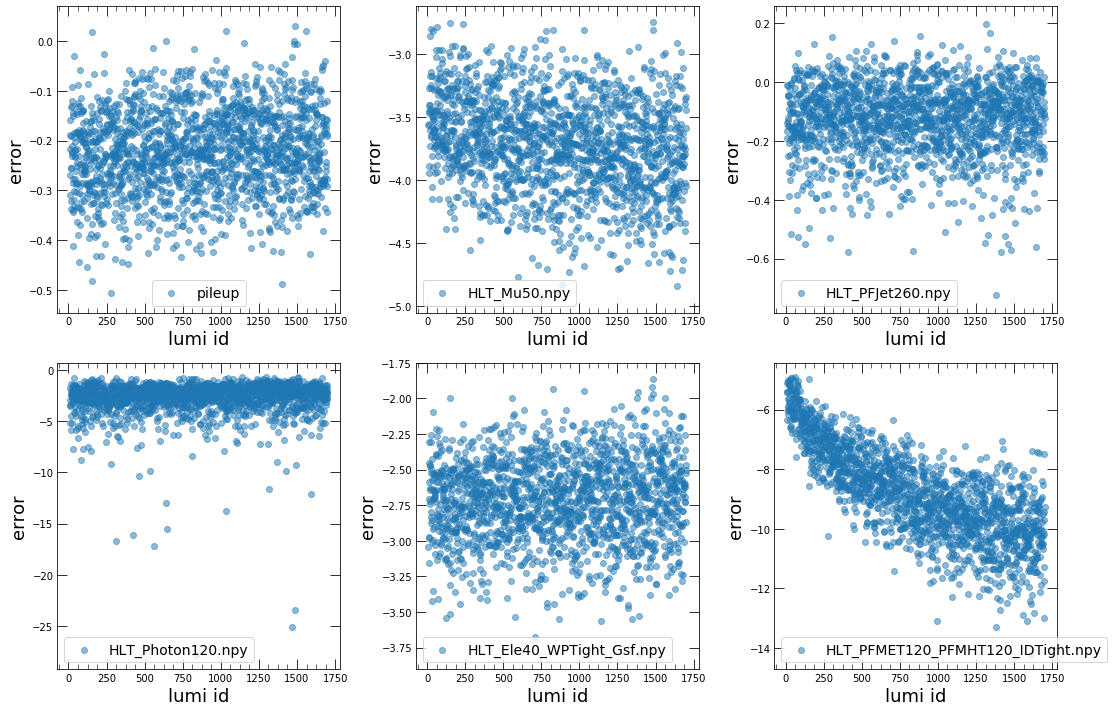

In [69]:
labels = ['pileup'] + data['HLT']
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

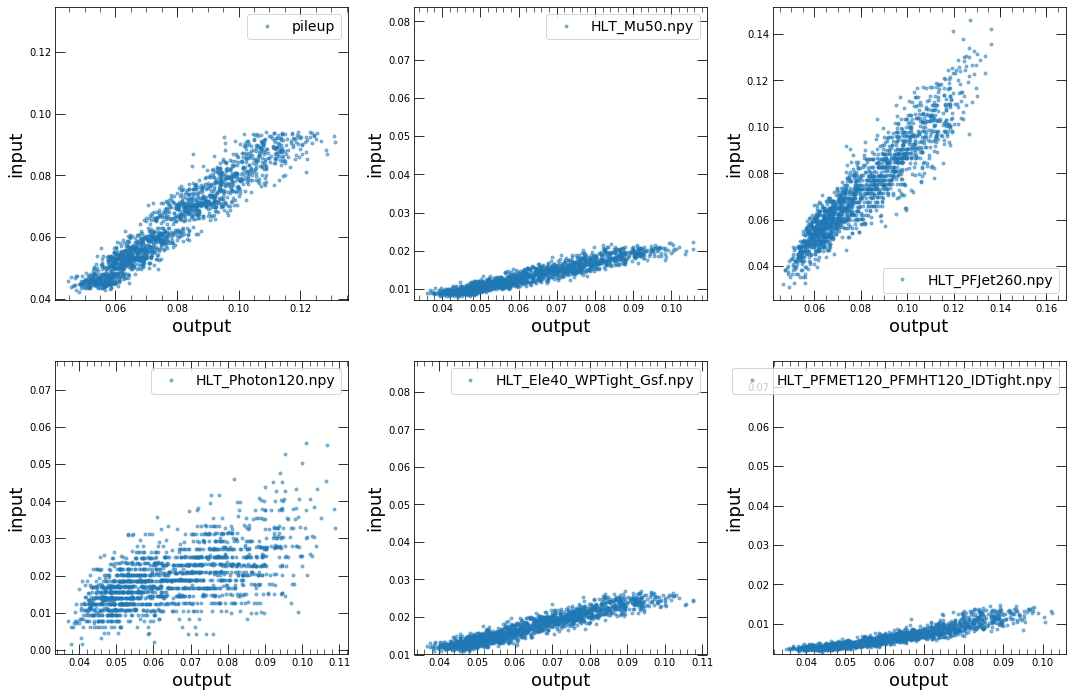

In [70]:
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

## Test Data

In [71]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = (x_test_new-reconstructed)/x_test_new

In [72]:
error_reformat = []
inp = []
outp = []
for i in range(6):
    error_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        error_reformat[j].append(error[i][j])
        outp[j].append(reconstructed[i][j])
        inp[j].append(x_test_new[i][j])

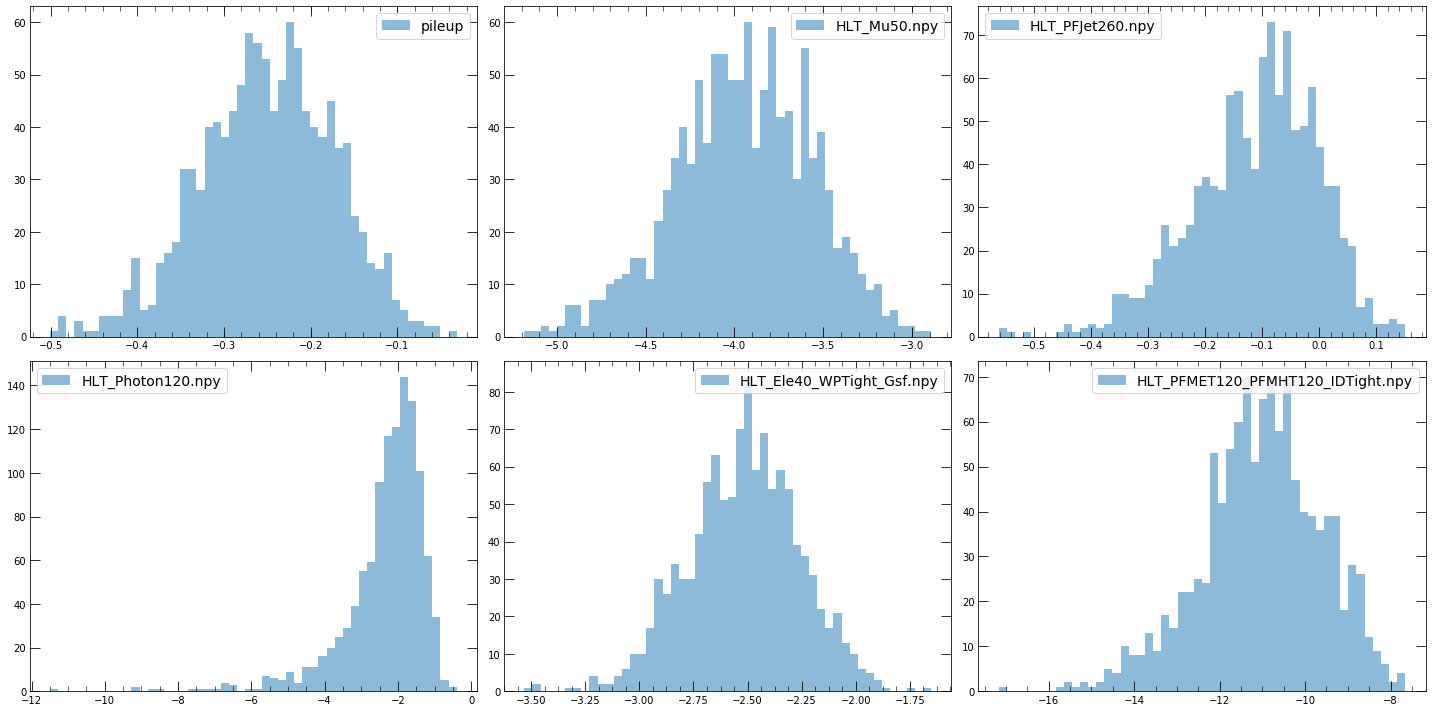

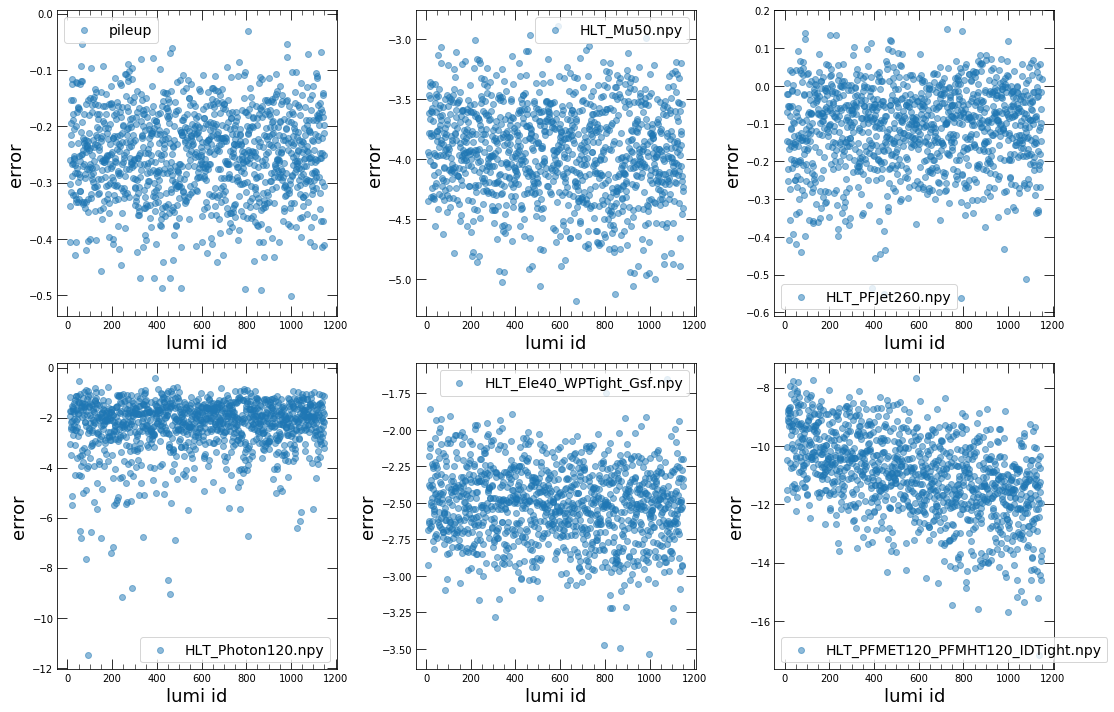

In [73]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

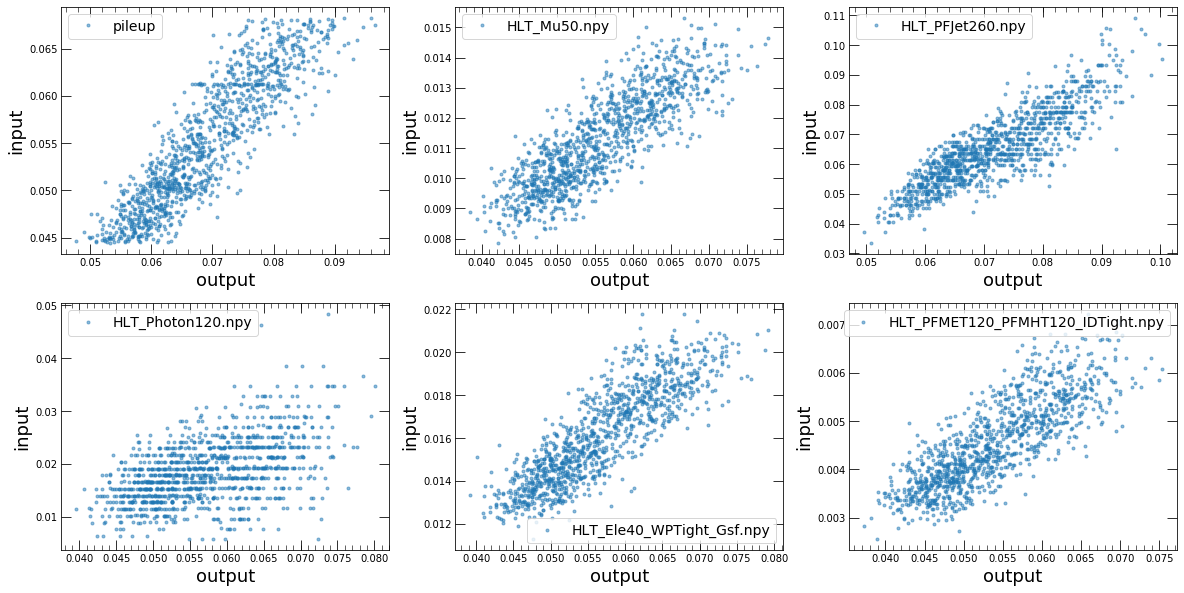

In [74]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [75]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [148]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [19]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [20]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [21]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])
            
        

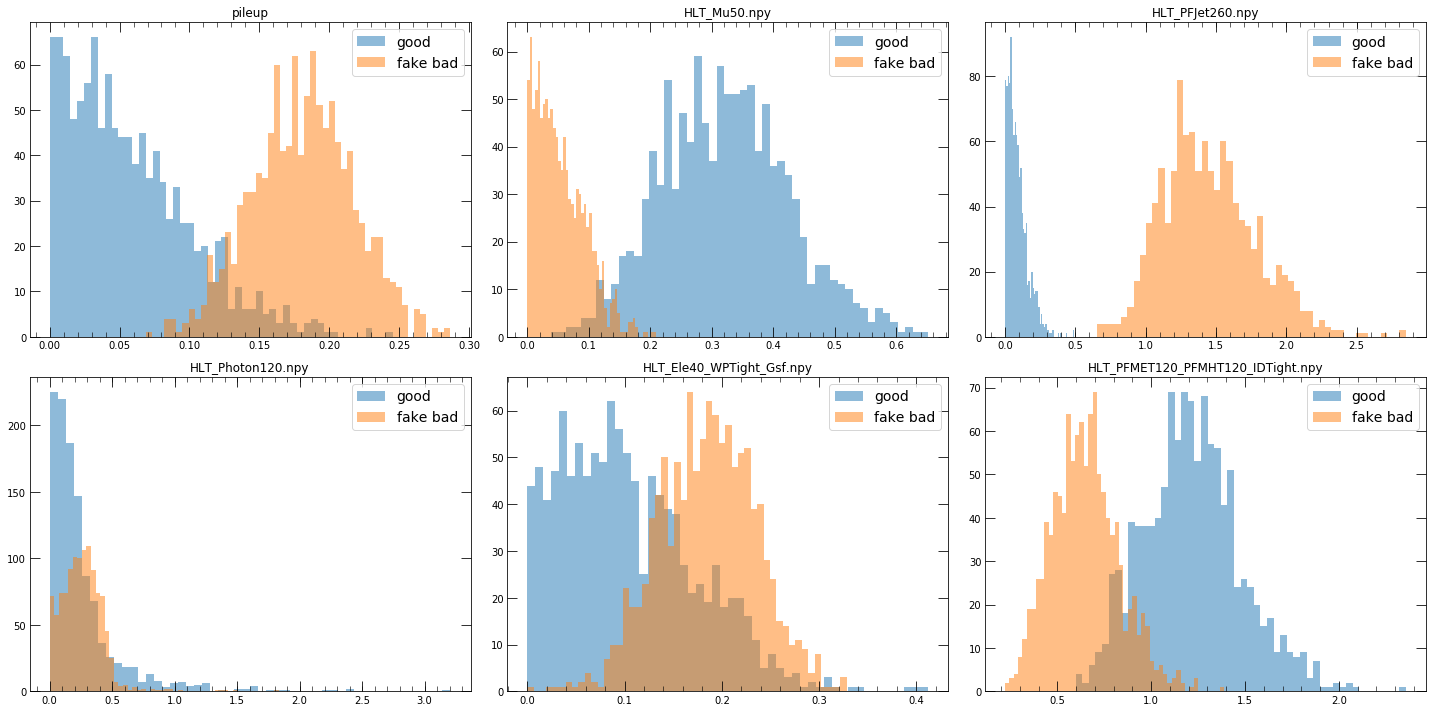

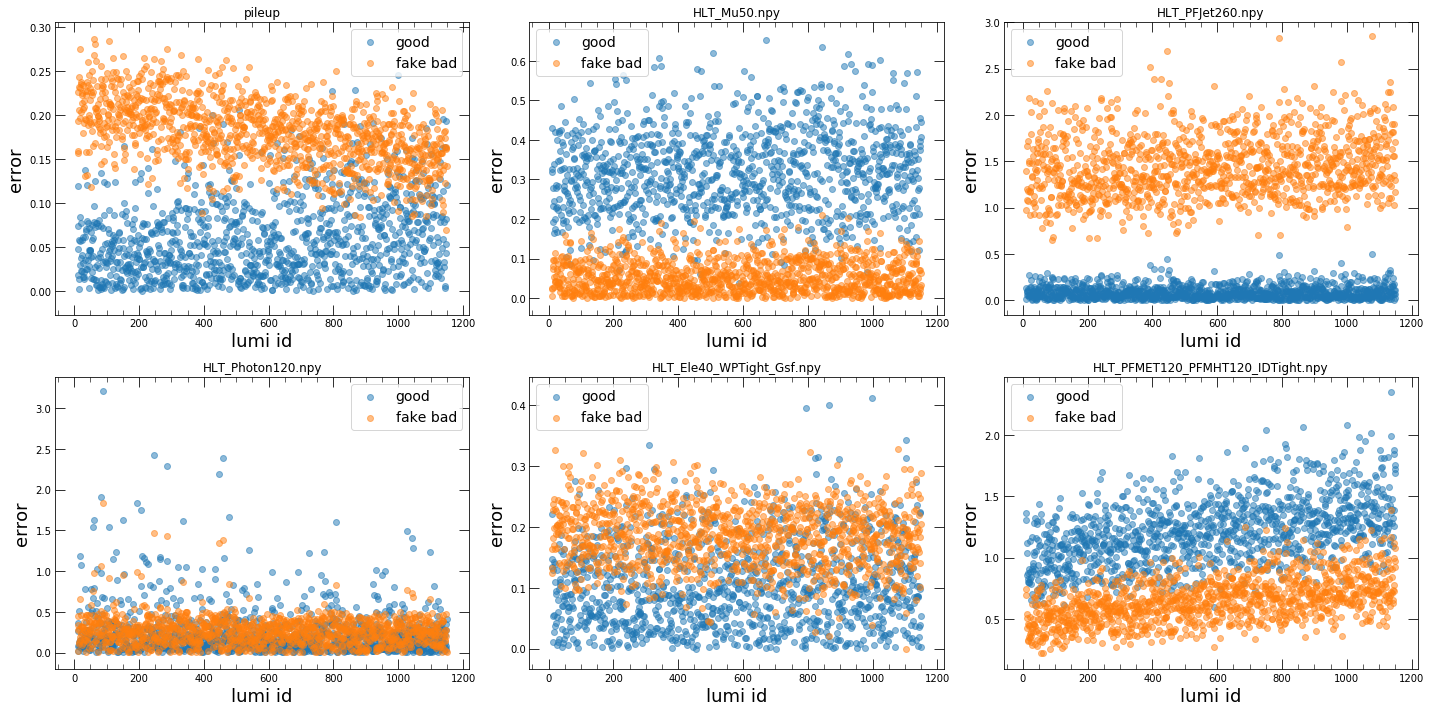

In [22]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

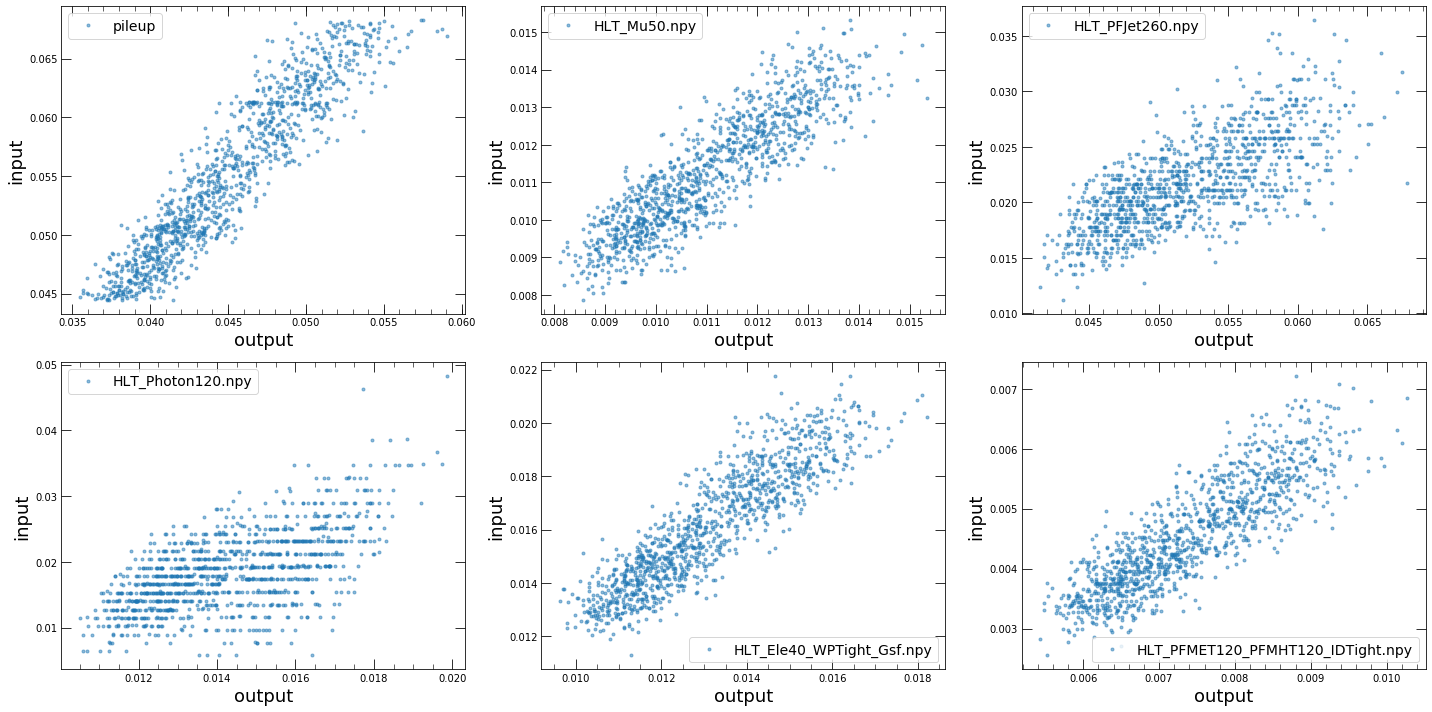

In [23]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    
plt.tight_layout()
plt.show()

In [24]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [25]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [26]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [27]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [28]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

1129 1129


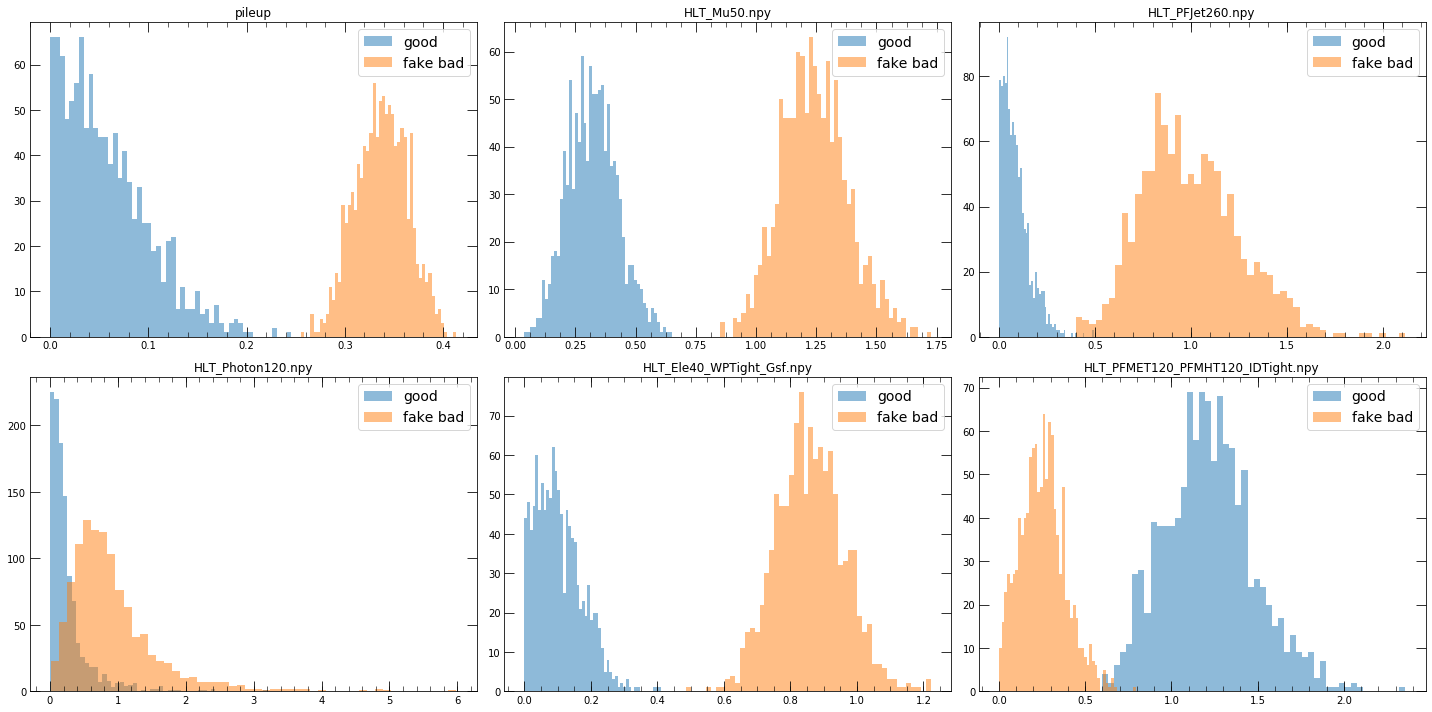

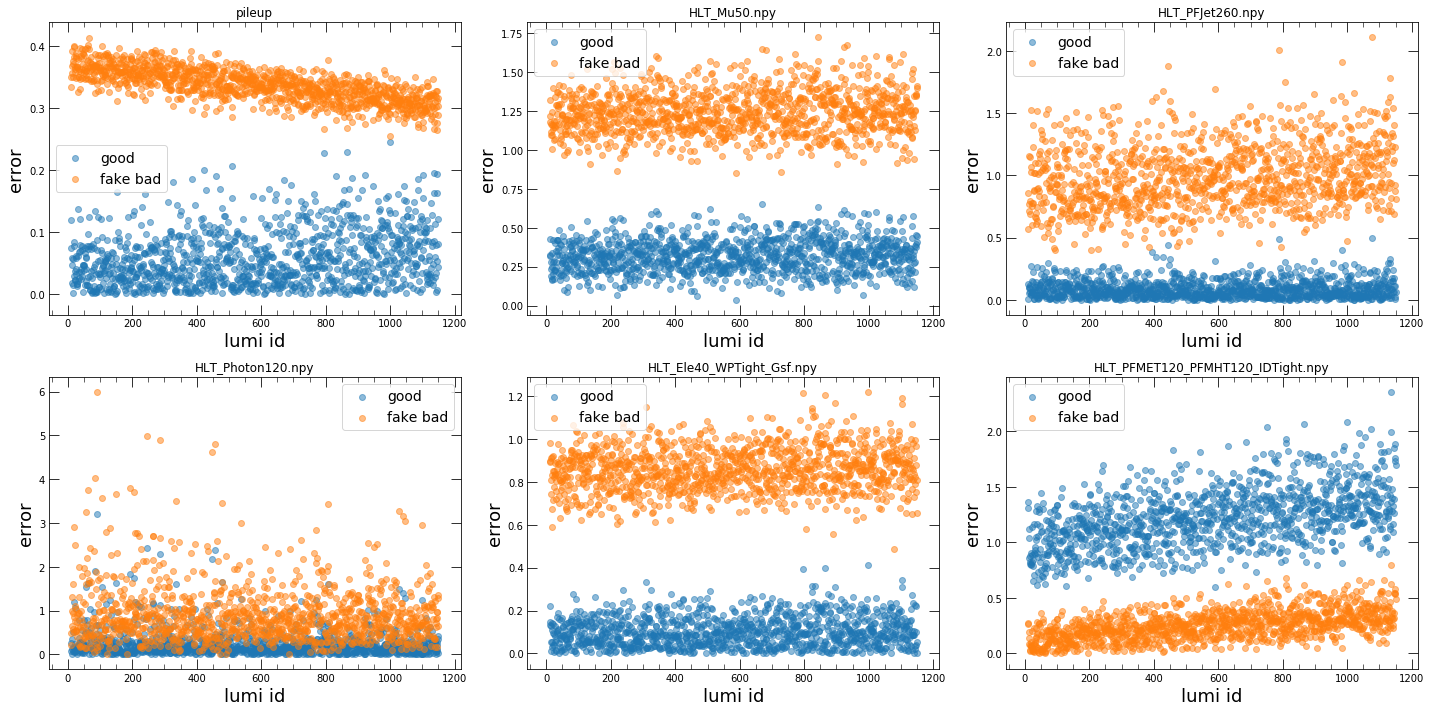

In [29]:
#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
    
plt.show()

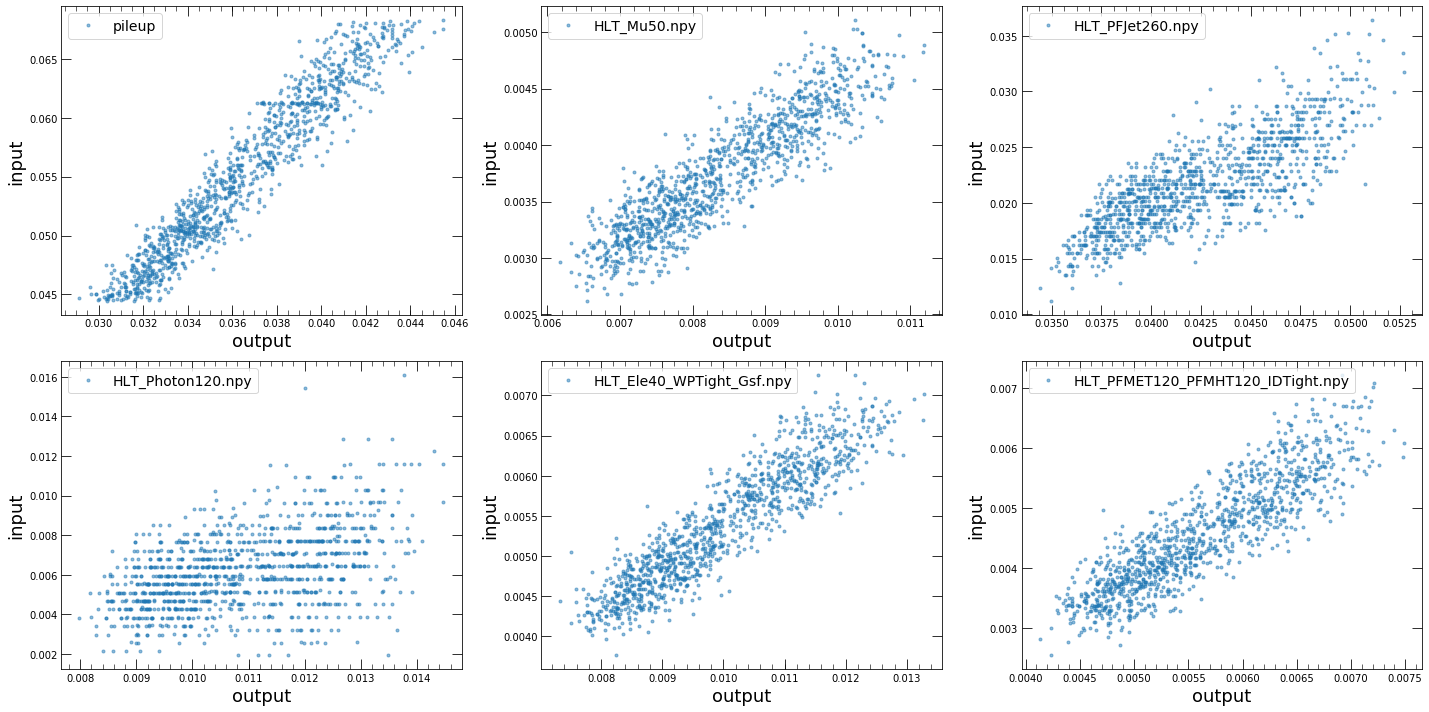

In [30]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.tight_layout()
    
plt.show()

In [31]:
# plt.figure(figsize=[15,10])
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [32]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,3,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(6):
# #     plt.subplot(2,3,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [33]:
bad_runs = [301480]

with open('pileupInput_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [34]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

NameError: name 'WINDOW' is not defined

In [ ]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

In [ ]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
#print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()   

plt.tight_layout()
plt.show()

## Real Bad Data

In [ ]:
bad_runs = [305588]
x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [ ]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
inp_bad = []
outp_bad = []
for i in range(6):
    error_reformat_bad.append([])
    inp_bad.append([])
    outp_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        error_reformat_bad[j].append(error_bad[i][j])
        outp_bad[j].append(reconstructed_bad[i][j])
        inp_bad[j].append(bad_new[i][j])

In [ ]:
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,3,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    
plt.tight_layout()
plt.show()